# Multi-modal Embedding using Multilingual CLIP (Dutch)

## Imports and Utilities

In [1]:
from sentence_transformers import SentenceTransformer, util, models, InputExample, losses
from PIL import Image
import glob
import torch
from torch.utils.data import DataLoader
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import pandas as pd
import os
from tqdm.autonotebook import tqdm, trange
import torch
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [2]:
image_folder = 'images/'
def show_image(img_id, img_folder=image_folder):
    try:
        image_link = img_folder + img_id + '.jpg'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    except:
        image_link = img_folder + img_id + '.png'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    plt.imshow(image)
    plt.show()

In [3]:
import random
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [4]:
df = pd.read_csv('data/tweets_subset.csv', index_col='Unnamed: 0').reset_index()
df[df.available].head()

,index,id,skepticism,mainstream,label,text_NL,text_EN,split,available,target,unseen_images
956,956,327027443732983808,False,True,1,"RT @USER : 3D waterkaart , hoe stroomt het wat...","RT @USER : 3D water map , how the water flows ...",test,True,3_327026285966667776,1
1211,1211,375896131127218176,False,True,1,Kom naar de Wilhelminakade R'dam en klim boven...,Come to the Wilhelminakade R'dam and climb abo...,val,True,3_375896131013971968,1
1212,1212,375899134915772416,False,True,1,RT @USER : Kom naar de Wilhelminakade R'dam en...,RT @USER : Come to the Wilhelminakade R'dam an...,val,True,3_375896131013971968,1
1214,1214,375946829881278464,False,True,1,Scholieren klimmen met Jeugdwaterschap naar ni...,Students climb to the water level of their hou...,val,True,3_375946829747089408,0
1215,1215,375946961951539200,False,True,1,RT @USER : Scholieren klimmen met Jeugdwatersc...,RT @USER : Students climb to the water level o...,train,True,3_375946829747089408,0


In [5]:
# We use the original CLIP model for computing image embeddings and English text embeddings
txt_model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')
img_model = SentenceTransformer('clip-ViT-B-32')
txt_tokenizer = txt_model.tokenizer
img_tokenizer = img_model._first_module().processor.tokenizer

In [6]:
def embed_documents(documents, embedding_model=txt_model, convert_to_tensor = True, verbose = False):
    """ Embed a list of n documents/words into an n-dimensional
    matrix of embeddings

    Arguments:
        documents: A list of documents or words to be embedded
        verbose: Controls the verbosity of the process

    Returns:
        Document/words embeddings with shape (n, m) with `n` documents/words
        that each have an embeddings size of `m`
    """
    truncated_docs = [truncate_document(doc) for doc in documents]
    embeddings = embedding_model.encode(truncated_docs, show_progress_bar=verbose, convert_to_tensor=convert_to_tensor)
    return embeddings

def truncate_document(document, tokenizer=txt_tokenizer):
    tokens = tokenizer.encode(document)

    if len(tokens) > 77:
        # Skip the starting token, only include 75 tokens
        truncated_tokens = tokens[1:76]
        document = tokenizer.decode(truncated_tokens)

        # Recursive call here, because the encode(decode()) can have different result
        return truncate_document(document)

    else:
        return document

In [7]:
df['text_NL_trun'] = df['text_NL'].apply(truncate_document)

In [8]:
def embed_images(images, verbose=True, batch_size=32, embedding_model=img_model, convert_to_tensor=True):
    if batch_size:
        nr_iterations = int(np.ceil(len(images) / batch_size))

        # Embed images per batch
        embeddings = []
        for i in tqdm(range(nr_iterations), disable=not verbose):
            start_index = i * batch_size
            end_index = (i * batch_size) + batch_size

            images_to_embed = [Image.open(img_name_dict[image]) if (isinstance(image, str) and not str(image)=='nan') 
                               else (Image.new('RGB', (800, 600), color = (255,255,255)) if str(image)=='nan'
                               else image) for image in images[start_index:end_index]]
            img_emb = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
            embeddings.extend(img_emb.tolist())

            # Close images
            if isinstance(images[0], str):
                for image in images_to_embed:
                    image.close()
        if not convert_to_tensor:
            embeddings = np.array(embeddings)
        else:
            embeddings = torch.tensor(embeddings).to(device='cuda')
    else:
        images_to_embed = [Image.open(filepath) for filepath in images]
        embeddings = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
    return embeddings

In [9]:
def return_report(labels, preds, ids=[]):
    if len(ids)==0:
        print(metrics.classification_report(labels.cpu(), preds.cpu(), digits=4))
        return metrics.classification_report(labels.cpu(), preds.cpu(), digits=4, output_dict=True)
    else:
        print(metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4))
        return metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4, output_dict=True)

def evaluate_dataset_F1(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    test = df[df['split'] == 'test'].index
    image = df[df['available']].index
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        temp = val.copy()
    elif val_set=='test':
        temp = test.copy()
    
    a = temp.intersection(image)
    b = temp.difference(image)
    c = temp.intersection(image).intersection(unseen)    
    
    print('Overall Dataset:')
    all_report = return_report(label_all, preds_all)
    
    print('Training Set:')
    train_report = return_report(label_all, preds_all, train)
    
    print('Validation Set:')
    val_report = return_report(label_all, preds_all, temp)
    
    print('Validation Set with both Images and Texts:')
    val_img_report = return_report(label_all, preds_all, a)
    
    print('Validation Set with only Texts:')
    val_txt_report = return_report(label_all, preds_all, b)
    
    print('Validation Set with unseen Images:')
    val_unseen_report = return_report(label_all, preds_all, c)
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    val_acc = ((label_all[torch.tensor(list(temp))]==preds_all[torch.tensor(list(temp))]).sum()/len(temp)).item()*100
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_report, train_report, val_report, val_img_report, val_txt_report, val_unseen_report

In [10]:
def evaluate_dataset(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    #train = torch.tensor(np.array(df_all['split'] == 'train')).to(device).float()
    train = df[df['split'] == 'train'].index
    #val = torch.tensor(np.array(df_all['split'] == 'val')).to(device).float()
    val = df[df['split'] == 'val'].index
    #test = torch.tensor(np.array(df_all['split'] == 'test')).to(device).float()
    test = df[df['split'] == 'test'].index
    #image = torch.tensor(np.array(df_all['available'])).to(device).float()
    image = df[df['available']].index
    #unseen = torch.tensor(np.array(df_all['unseen_images'])).to(device).float()
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        a = val.intersection(image)
        b = val.difference(image)
        c = val.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(val))]==preds_all[torch.tensor(list(val))]).sum()/len(val)).item()*100
            
    elif val_set=='test':
        a = test.intersection(image)
        b = test.difference(image)
        c = test.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(test))]==preds_all[torch.tensor(list(test))]).sum()/len(test)).item()*100
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen

## Process Raw Data into Embeddings

Two sentences to compute embeddings

In [11]:
labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
          'Climate change is not even a real problem to concern about! I do not believe in it!']
lab_emb = txt_model.encode(labels, convert_to_tensor=True)
empty_img_emb = embed_images(['nan'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
empty_img_emb.shape

torch.Size([1, 512])

In [ ]:
txt_emb = embed_documents(list(df['text_NL']), convert_to_tensor=True, verbose=True)

In [ ]:
img_emb = embed_images(list(df['target']), convert_to_tensor=True)

In [ ]:
import pickle
with open('data/CLIP_ML_NL/embeddings.pkl', "wb") as fOut:
    pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 
                 'lab_emb': lab_emb, 'empty_img_emb': empty_img_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('data/CLIP_ML_NL/embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    #stored_sentences = stored_data['sentences']
    txt_emb = stored_data['txt_emb']
    img_emb = stored_data['img_emb']
    lab_emb = stored_data['lab_emb']
    empty_img_emb = stored_data['empty_img_emb']

labs = {}
labs['txt_emb'] = lab_emb
labs['img_emb'] = torch.vstack([empty_img_emb] * lab_emb.shape[0])
mul_emb = (img_emb + txt_emb)/2

## Zero-shot Classification

Using Cosine Similarity to make classification

In [14]:
def zero_shot(df_all, model_name='CLIP_ML_NL', merge = 'average', from_stored_embedding=False, pre_computed = True,
             stored_data='', embedding_model = '', val_set='val'):
    
    if from_stored_embedding:
        folder = 'model_storage/{}/embeddings.pkl'.format(model_name)
        with open(folder, "rb") as fIn:
            stored_data = pickle.load(fIn)
            #stored_sentences = stored_data['sentences']
            txt_emb = stored_data['txt_emb']
            img_emb = stored_data['img_emb']
            lab_emb = stored_data['lab_emb']
    elif pre_computed:
        stored_data = stored_data
        #stored_sentences = stored_data['sentences']
        txt_emb = stored_data['txt_emb']
        img_emb = stored_data['img_emb']
        lab_emb = stored_data['lab_emb']
    else:
        txt_emb = embed_documents(list(df_all['text_EN_trun']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        img_emb = embed_images(list(df_all['target']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
                  'Climate change is not even a real problem to concern about! I do not believe in it!']
        lab_emb = embedding_model.encode(labels, convert_to_tensor=True)
        with open('model_storage/CLIP/embeddings_re.pkl', "wb") as fOut:
            pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 'lab_emb': lab_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    
    if merge == 'average':
        mul_emb = (img_emb + txt_emb)/2
    elif merge == 'max':
        mul_emb = torch.max(img_emb, txt_emb)
    else:
        print("'Merger' input must be one of 'average' or 'max'")
    
    TXT_LAB = util.cos_sim(lab_emb, txt_emb)
    IMG_LAB = util.cos_sim(lab_emb, img_emb)
    MUL_LAB = util.cos_sim(lab_emb, mul_emb)
    
    pred_TXT = torch.argmax(TXT_LAB[:2,:], dim=0).float()
    pred_IMG = torch.argmax(IMG_LAB[:2,:], dim=0).float()
    pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
    
    lab = torch.tensor(np.array(df_all['skepticism'])).to('cuda').float()
    
    set_seed_everywhere(42, cuda=True)
    lab_rand = (torch.rand(len(lab))>0.5).float().to('cuda')
    
    print('Using textual embedding only:')
    evaluate_dataset(df_all, pred_TXT, val_set=val_set)
    
    print('Using image embedding only:')
    evaluate_dataset(df_all, pred_IMG, val_set=val_set)
    
    print('Using multi-modal embedding:')
    evaluate_dataset(df_all, pred_MUL, val_set=val_set)
    
    print('Comparing to a random prediction:')
    evaluate_dataset(df_all, lab_rand, val_set=val_set)
    
    print('Test set performance multi-modal:')
    evaluate_dataset(df_all, pred_MUL, val_set='test')
    
    return

In [15]:
zero_shot(df, stored_data = stored_data)

Using textual embedding only:

    Overall Accuracy: 61.21
    Training Set Accuracy: 61.37
    Validation Set Accuracy: 61.30
    Validation Set with both Images and Texts: 67.83
    Validation Set with only Texts: 60.09
    Validation Set with unseen Images: 63.77
    
Using image embedding only:

    Overall Accuracy: 44.69
    Training Set Accuracy: 44.82
    Validation Set Accuracy: 45.17
    Validation Set with both Images and Texts: 59.83
    Validation Set with only Texts: 42.47
    Validation Set with unseen Images: 61.28
    
Using multi-modal embedding:

    Overall Accuracy: 49.72
    Training Set Accuracy: 49.71
    Validation Set Accuracy: 50.02
    Validation Set with both Images and Texts: 66.17
    Validation Set with only Texts: 47.05
    Validation Set with unseen Images: 64.18
    
Comparing to a random prediction:

    Overall Accuracy: 49.64
    Training Set Accuracy: 49.67
    Validation Set Accuracy: 49.99
    Validation Set with both Images and Texts: 48.09
   

## Training an additional MLP

In [16]:
from argparse import Namespace
args = Namespace(
    # Data and Path information
    model_state_file='MLP_classifier.pth',
    save_dir='model_storage/CLIP_ML_NL/',
    result_dir='results/CLIP_ML_NL/',
    embedding_size=512,
    early_stopping_criteria=20,
    num_epochs=20,
    seed=42,
    
    # Training hyper parameters
    batch_size=32,
    embedding_type='text',
    fusion_type='average',
    hidden_dim=128, 
    learning_rate=5e-5,
    l2=1e-5,
    dropout_p=0.1,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    device= 'cuda',
    cuda=True,
    verbose=True,
)

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MLPClassifier(nn.Module):
    
    def __init__(self, embedding_size, embedding_type, fusion_type, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
            fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                                {'average', 'concat', 'complex'}
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained embeddings
            
        """
        super(MLPClassifier, self).__init__()

        self.embedding_type = embedding_type
        self.fusion_type = fusion_type
        self._dropout_p = dropout_p
        self.dropout = nn.Dropout(dropout_p)
        #self.prelu = nn.PReLU()
        
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        self.fc_concat = nn.Linear(2*embedding_size, hidden_dim)
        self.fc_complex = nn.Linear(5*embedding_size, 2*embedding_size)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (dictionary): a dictionary of input data tensors with embeddings. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = x_in
                
        # logistic regression
        if (not self.embedding_type=='multi') or self.fusion_type=='average':
            intermediate_vector = F.relu(self.dropout(self.fc1(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='concat':
            intermediate_vector = F.relu(self.dropout(self.fc_concat(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='complex':
            first_vector = F.relu(self.dropout(self.fc_complex(x_embedded)))
            intermediate_vector = F.relu(self.dropout(self.fc_concat(first_vector)))
            prediction_vector = self.fc2(intermediate_vector)
        
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [18]:
class CustomDataset(Dataset):
    def __init__(self, df_all, embeddings):
        self.df = df_all
        self.labels = torch.tensor(np.array(self.df['skepticism'])).to(args.device).float()
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, self.df.text_EN_trun)) + 0
        self.embeddings = embeddings
        
        train = torch.tensor(df[df['split'] == 'train'].index)
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.train_emb = self.embeddings[train]
        
        val = torch.tensor(df[df['split'] == 'val'].index)
        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)
        self.val_emb = self.embeddings[val]
                
        test = torch.tensor(df[df['split'] == 'test'].index)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.test_emb = self.embeddings[test]

        self._lookup_dict = {'train': (self.train_df, self.train_size, self.train_emb),
                             'val': (self.val_df, self.validation_size, self.val_emb),
                             'test': (self.test_df, self.test_size, self.test_emb)}

        self.set_split('train')
            
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size, self._target_emb = self._lookup_dict[split]
        
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        if len(self) % batch_size==0:
            return len(self) // batch_size
        else:
            return len(self) // batch_size + 1

    def __len__(self):
        return self._target_size

    def __getitem__(self, idx):
        emb = self._target_emb[idx].to(args.device)
        row = self._target_df.iloc[idx]
        label = torch.tensor(row[['mainstream', 'skepticism']].astype(int)).to(args.device)
        
        return {'emb': emb, 
                'label': label}

In [19]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_1_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'golden_loss': [],
            'train_loss': [],
            'train_1_acc': [],
            'train_acc': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_acc': [],
            'val_img_txt': [],
            'val_txt_only': [],
            'val_unseen_img': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_acc': -1,
            'test_img_txt': -1,
            'test_txt_only': -1,
            'test_unseen_img': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_1_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_1_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_1_acc_val']:
                train_state['early_stopping_best_1_acc_val'] = acc_t
                torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [20]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [21]:
def softmax_sensitive(T):
    T = np.exp(T) - np.exp(0) + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [22]:
def prepare_embedding(embeddings, embedding_type, fusion_type):
    '''
    Args:
        embeddings (dictionary): a dictionary of input data tensors with embeddings. 
        embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
        fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                        {'average', 'concat', 'complex'}'''
    if embedding_type=='text':
        x_embedded = embeddings['txt_emb']
    elif embedding_type=='image':
        x_embedded = embeddings['img_emb']
    elif embedding_type=='multi':
        if fusion_type=='average':
            x_embedded = (embeddings['txt_emb']+embeddings['img_emb'])/2
        elif fusion_type=='concat':
            x_embedded = torch.hstack([embeddings['txt_emb'], embeddings['img_emb']])
        elif fusion_type=='complex':
            txt_emb = embeddings['txt_emb']
            img_emb = embeddings['img_emb']
            x_embedded = torch.hstack([txt_emb, img_emb, txt_emb+img_emb, txt_emb-img_emb, txt_emb*img_emb])
        else:
            print('fusion_type is not supported')
    else:
        print('embedding_type is not supported')
        
    return x_embedded

In [23]:
def initialization(df, stored_data):
    set_seed_everywhere(args.seed, args.cuda)
    embeddings = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
    dataset = CustomDataset(df, embeddings)
    
    classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
    
    return embeddings, dataset, classifier

In [24]:
def write_train_state_evaluation(classifier, embeddings, train_state, df):
    preds_all = classifier(embeddings).argmax(dim=1)
    _, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen = evaluate_dataset(df, preds_all)
    
    train_state['train_acc'].append(train_acc)
    train_state['val_acc'].append(val_acc)
    train_state['val_img_txt'].append(val_img_acc)
    train_state['val_txt_only'].append(val_txt_acc)
    train_state['val_unseen_img'].append(val_unseen)
    
    return train_state

In [25]:
def training_loop(df, stored_data, labs=None, verbose=True):
    
    embeddings, dataset, classifier = initialization(df, stored_data)
    if labs:
        lab_embeddings = prepare_embedding(labs, args.embedding_type, args.fusion_type)
    classifier = classifier.to(args.device)

    loss_func = cross_entropy
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)
    train_state = make_train_state(args)
    
    print('Using {} embedding with {} fusion method'.format(args.embedding_type, args.fusion_type))
    
    set_seed_everywhere(args.seed, cuda=True)
    train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
    
    set_seed_everywhere(args.seed, cuda=True)
    try:
        for epoch_index in trange(args.num_epochs, desc="Epoch", disable=not args.verbose):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            train_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
            
            running_loss = 0.0
            running_1_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(train_dataloader):

                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']

                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()

                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)
                
                # step 5. use loss to produce gradients
                loss.backward()

                # step 6. use optimizer to take gradient step
                optimizer.step()

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)
            
            if labs:
                optimizer.zero_grad()
                y_pred = classifier(lab_embeddings)
                y = torch.tensor([[1,0], [0,1]]).to(args.device)
                loss = loss_func(y_pred, y)
                loss.backward()
                optimizer.step()
                train_state['golden_loss'].append(loss.item())
            else:
                train_state['golden_loss'].append('not implemented')
            
            train_state['train_loss'].append(running_loss)
            train_state['train_1_acc'].append(running_1_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on

            dataset.set_split('val')
            val_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

            running_loss = 0.0
            running_1_acc = 0.0
            classifier.eval()

            for batch_index, batch_dict in enumerate(val_dataloader):

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']
                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()
                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)

            train_state['val_loss'].append(running_loss)
            train_state['val_1_acc'].append(running_1_acc)

            train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
            
            print('Current Running Accuracy Training Set: {:.2f}, Validation Set: {:.2f}, Golden Set: {:.2f}'.format(train_state['train_1_acc'][-1], train_state['val_1_acc'][-1], train_state['golden_loss'][-1]))

            train_state = update_train_state(args=args, model=classifier, train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            with open(args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + 'train_state.p', 'wb') as fp:
                pickle.dump(train_state, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [26]:
def experiment(df, stored_data, labs = None, hyperdict={}):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for key in combi:
        print(key)
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        if not key in hyperdict:
            train_state = training_loop(df, stored_data, labs=labs)
            hyperdict[key] = train_state
            
        with open(args.save_dir+'hyperdict.p', 'wb') as fp:
            pickle.dump(hyperdict,fp, protocol=pickle.HIGHEST_PROTOCOL)    

In [27]:
def demonstration(hyperdict):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    metrics = ['train_acc', 'val_acc', 'val_img_txt', 'val_txt_only', 'val_unseen_img']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for m in metrics:
        print(m)
        for key in combi:
            train_state = hyperdict[key]
            pd.Series(train_state[m]).plot(label=str(key))
            plt.legend()
        plt.show()

In [28]:
def statistics(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [34]:
def statistics_F1(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        #pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset_F1(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset_F1(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [ ]:
hyperdict = {}
experiment(df, stored_data, hyperdict)

In [ ]:
hyperdict = {}
experiment(df, stored_data, labs, hyperdict)

## Performance on Trained Models

In [30]:
perform_results = {}
for o in ['O1', 'O2']:
    perform_results[o] = {}

In [31]:
with open(args.save_dir+'001/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


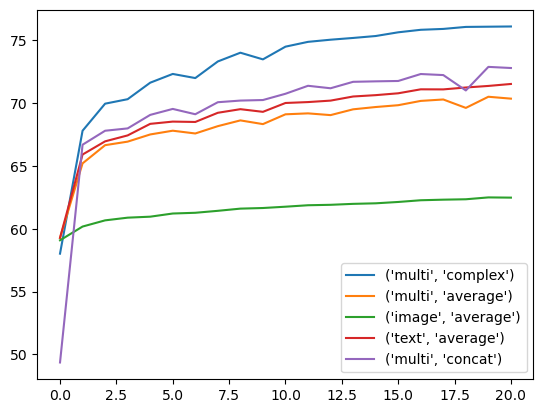

val_acc


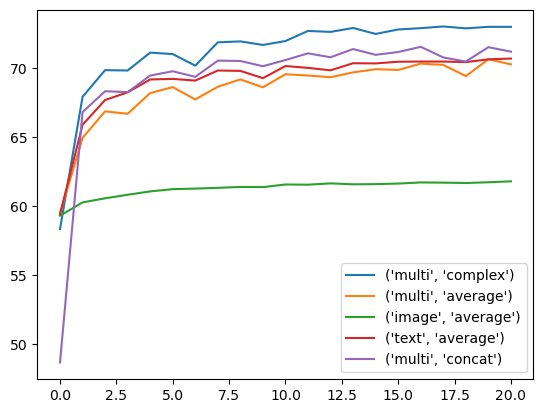

val_img_txt


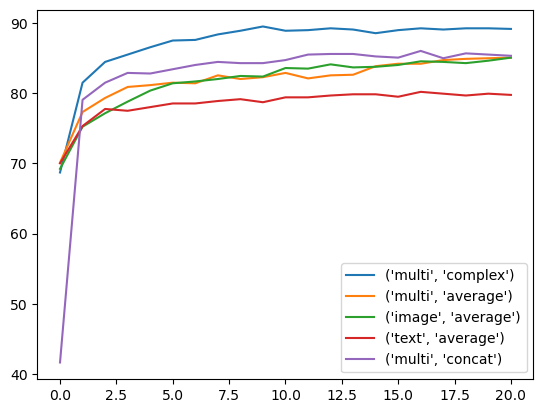

val_txt_only


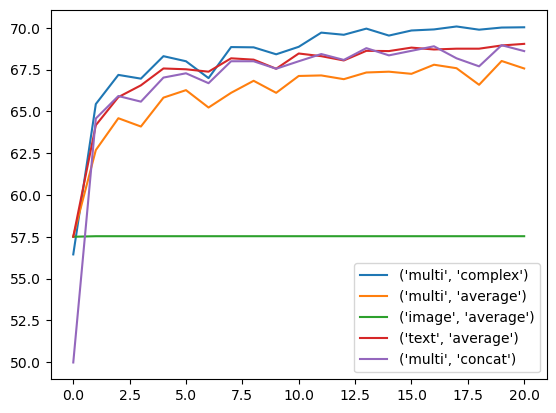

val_unseen_img


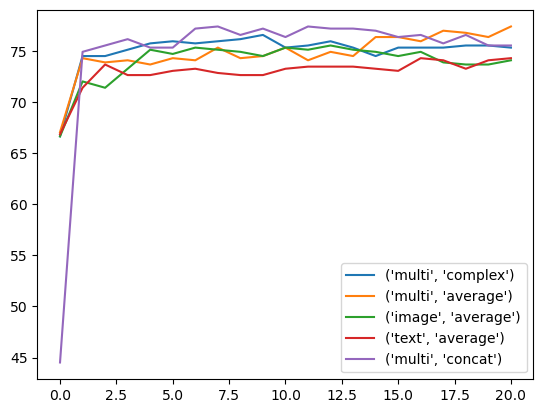

In [32]:
demonstration(hyperdict)

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8071    0.7592    0.7824     29306
         1.0     0.6755    0.7343    0.7037     20010

    accuracy                         0.7491     49316
   macro avg     0.7413    0.7467    0.7431     49316
weighted avg     0.7537    0.7491    0.7505     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8157    0.7664    0.7903     20463
         1.0     0.6875    0.7479    0.7164     14058

    accuracy                         0.7589     34521
   macro avg     0.7516    0.7572    0.7533     34521
weighted avg     0.7635    0.7589    0.7602     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7895    0.7452    0.7667      4400
         1.0     0.6544    0.7084    0.6803      2997

    accuracy                         0.7303      7397
   macro avg     0.7220    0.7268    0.7235

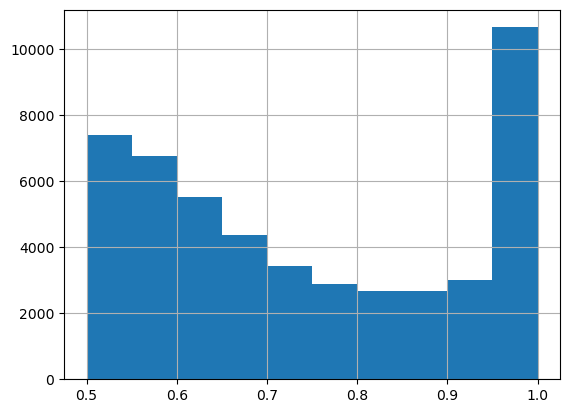

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7474    0.7592    0.7532     29306
         1.0     0.6390    0.6242    0.6315     20010

    accuracy                         0.7044     49316
   macro avg     0.6932    0.6917    0.6924     49316
weighted avg     0.7034    0.7044    0.7038     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7479    0.7577    0.7527     20463
         1.0     0.6404    0.6282    0.6342     14058

    accuracy                         0.7049     34521
   macro avg     0.6941    0.6929    0.6935     34521
weighted avg     0.7041    0.7049    0.7045     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7463    0.7675    0.7568      4400
         1.0     0.6438    0.6170    0.6301      2997

    accuracy                         0.7065      7397
   macro avg     0.6951    0.6922    0.6934

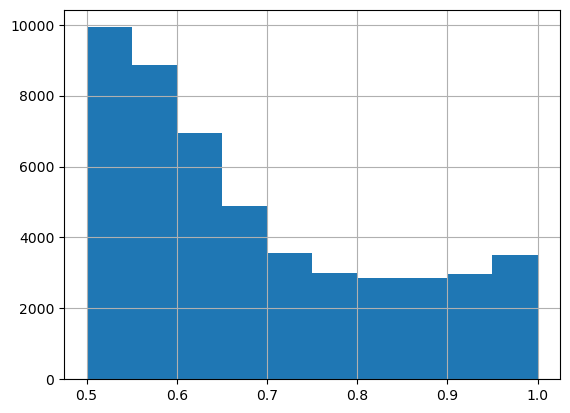

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6135    0.9901    0.7575     29306
         1.0     0.8562    0.0863    0.1568     20010

    accuracy                         0.6234     49316
   macro avg     0.7348    0.5382    0.4572     49316
weighted avg     0.7120    0.6234    0.5138     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6134    0.9921    0.7581     20463
         1.0     0.8870    0.0899    0.1633     14058

    accuracy                         0.6247     34521
   macro avg     0.7502    0.5410    0.4607     34521
weighted avg     0.7248    0.6247    0.5159     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6110    0.9852    0.7542      4400
         1.0     0.7848    0.0791    0.1437      2997

    accuracy                         0.6181      7397
   macro avg     0.6979    0.5322    0.4490

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

Training Set:
              precision    recall  f1-score   support

         0.0     0.6134    0.9921    0.7581     20463
         1.0     0.8870    0.0899    0.1633     14058

    accuracy                         0.6247     34521
   macro avg     0.7502    0.5410    0.4607     34521
weighted avg     0.7248    0.6247    0.5159     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6161    0.9856    0.7582      4443
         1.0     0.7793    0.0765    0.1393      2955

    accuracy                         0.6225      7398
   macro avg     0.6977    0.5310    0.4487      7398
weighted avg     0.6813    0.6225    0.5110      7398

Validation Set with both Images and Texts:
              precision    recall  f1-score   support

         0.0     0.8424    0.9106    0.8752       716
         1.0     0.7793    0.6494    0.7085       348

    accuracy                         0.8252      1064
   macro avg     0.8108    0.7800    0.7918      1064
w

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

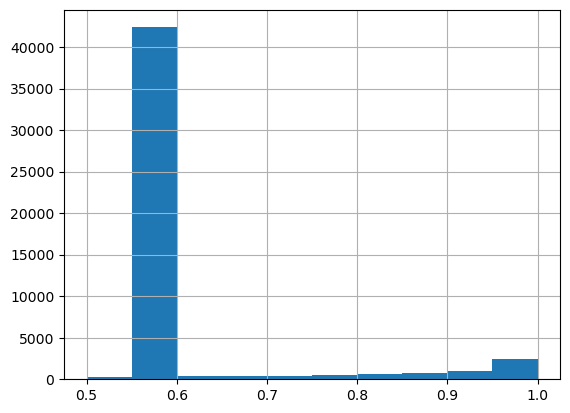

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7541    0.7663    0.7602     29306
         1.0     0.6494    0.6340    0.6416     20010

    accuracy                         0.7126     49316
   macro avg     0.7018    0.7002    0.7009     49316
weighted avg     0.7116    0.7126    0.7121     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7559    0.7670    0.7614     20463
         1.0     0.6535    0.6395    0.6464     14058

    accuracy                         0.7151     34521
   macro avg     0.7047    0.7033    0.7039     34521
weighted avg     0.7142    0.7151    0.7146     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7479    0.7655    0.7566      4400
         1.0     0.6434    0.6213    0.6322      2997

    accuracy                         0.7070      7397
   macro avg     0.6957    0.6934    0.6944 

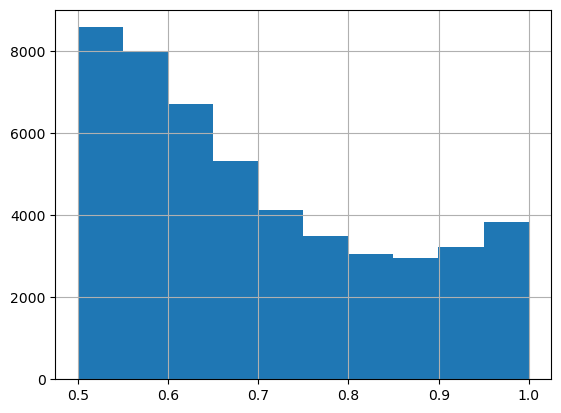

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7834    0.7322    0.7569     29306
         1.0     0.6420    0.7035    0.6714     20010

    accuracy                         0.7206     49316
   macro avg     0.7127    0.7179    0.7142     49316
weighted avg     0.7261    0.7206    0.7222     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7855    0.7328    0.7582     20463
         1.0     0.6457    0.7088    0.6758     14058

    accuracy                         0.7230     34521
   macro avg     0.7156    0.7208    0.7170     34521
weighted avg     0.7286    0.7230    0.7247     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7780    0.7302    0.7533      4400
         1.0     0.6367    0.6940    0.6641      2997

    accuracy                         0.7156      7397
   macro avg     0.7073    0.7121    0.7087 

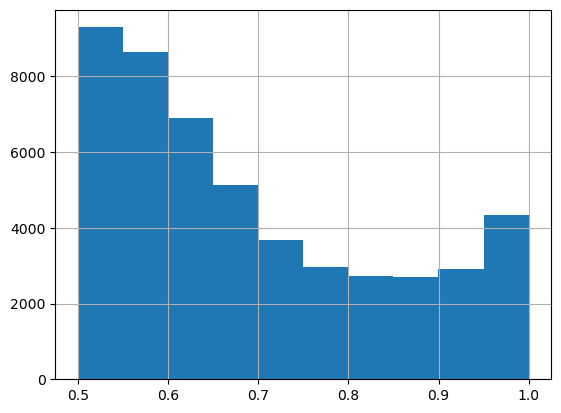

In [33]:
perform_results['O1'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='001/')

In [35]:
with open(args.save_dir+'002/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


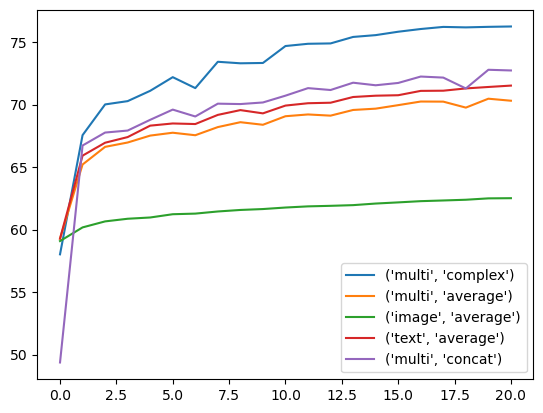

val_acc


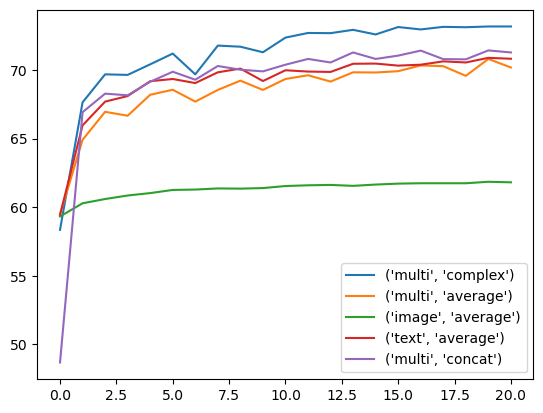

val_img_txt


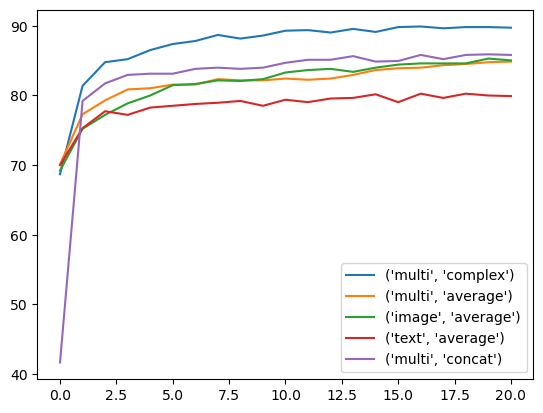

val_txt_only


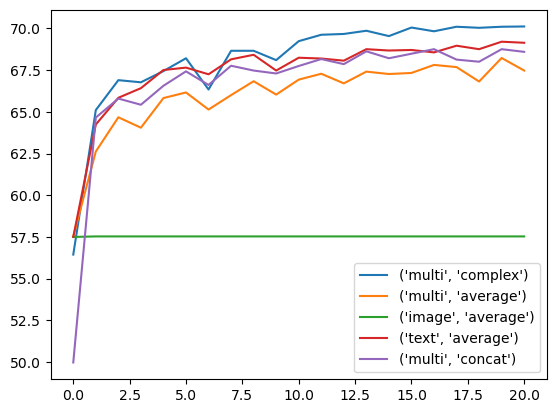

val_unseen_img


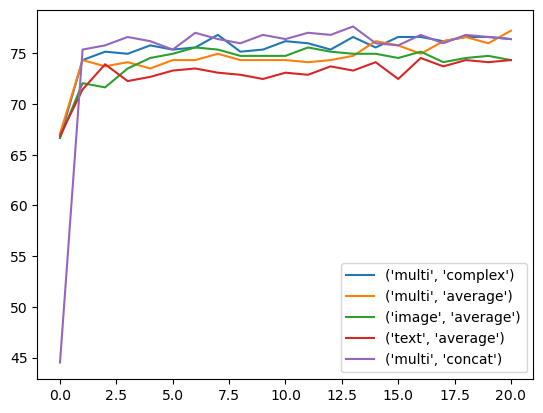

In [36]:
demonstration(hyperdict)

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8063    0.7679    0.7866     29306
         1.0     0.6822    0.7298    0.7052     20010

    accuracy                         0.7525     49316
   macro avg     0.7443    0.7489    0.7459     49316
weighted avg     0.7560    0.7525    0.7536     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8147    0.7757    0.7948     20463
         1.0     0.6948    0.7432    0.7182     14058

    accuracy                         0.7625     34521
   macro avg     0.7548    0.7595    0.7565     34521
weighted avg     0.7659    0.7625    0.7636     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7878    0.7511    0.7691      4400
         1.0     0.6580    0.7030    0.6798      2997

    accuracy                         0.7316      7397
   macro avg     0.7229    0.7271    0.7244

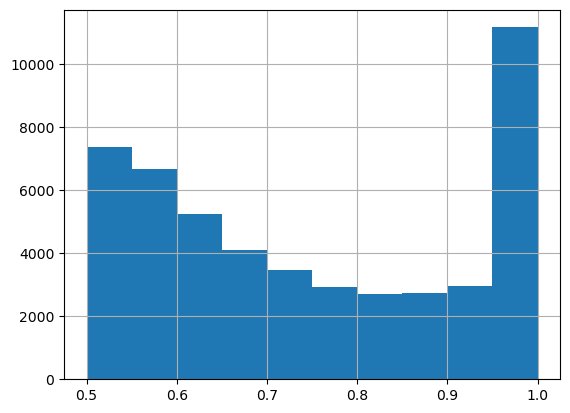

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7461    0.7618    0.7539     29306
         1.0     0.6400    0.6202    0.6300     20010

    accuracy                         0.7044     49316
   macro avg     0.6931    0.6910    0.6919     49316
weighted avg     0.7030    0.7044    0.7036     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7462    0.7606    0.7533     20463
         1.0     0.6414    0.6233    0.6323     14058

    accuracy                         0.7047     34521
   macro avg     0.6938    0.6920    0.6928     34521
weighted avg     0.7035    0.7047    0.7040     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7473    0.7691    0.7581      4400
         1.0     0.6459    0.6183    0.6318      2997

    accuracy                         0.7080      7397
   macro avg     0.6966    0.6937    0.6949

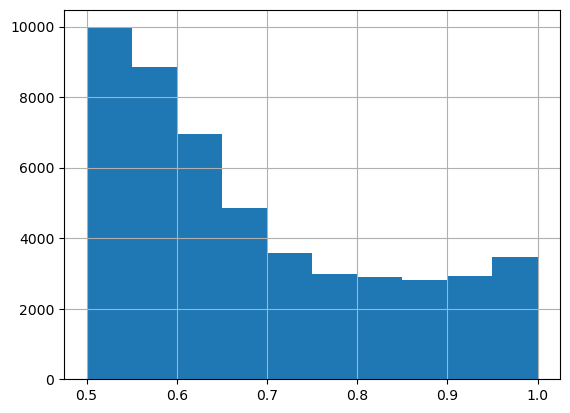

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6139    0.9882    0.7573     29306
         1.0     0.8382    0.0896    0.1619     20010

    accuracy                         0.6236     49316
   macro avg     0.7261    0.5389    0.4596     49316
weighted avg     0.7049    0.6236    0.5157     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6138    0.9902    0.7579     20463
         1.0     0.8676    0.0933    0.1684     14058

    accuracy                         0.6250     34521
   macro avg     0.7407    0.5417    0.4631     34521
weighted avg     0.7172    0.6250    0.5178     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6114    0.9839    0.7542      4400
         1.0     0.7760    0.0821    0.1485      2997

    accuracy                         0.6185      7397
   macro avg     0.6937    0.5330    0.4513

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

         0.0     0.6139    0.9882    0.7573     29306
         1.0     0.8382    0.0896    0.1619     20010

    accuracy                         0.6236     49316
   macro avg     0.7261    0.5389    0.4596     49316
weighted avg     0.7049    0.6236    0.5157     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6138    0.9902    0.7579     20463
         1.0     0.8676    0.0933    0.1684     14058

    accuracy                         0.6250     34521
   macro avg     0.7407    0.5417    0.4631     34521
weighted avg     0.7172    0.6250    0.5178     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6163    0.9831    0.7577      4443
         1.0     0.7588    0.0799    0.1445      2955

    accuracy                         0.6223      7398
   macro avg     0.6876    0.5315    0.4511      7398
weighted avg     0.6733    0.6223    0.5128 

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

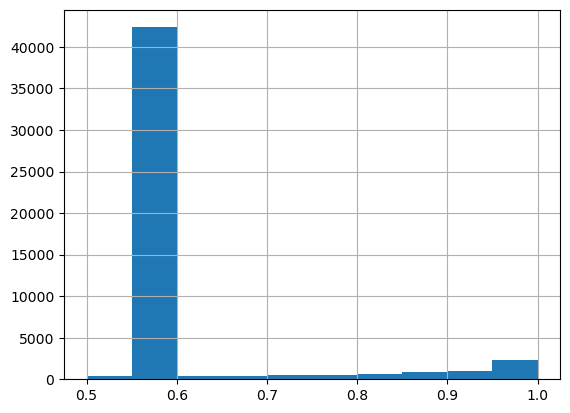

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7495    0.7758    0.7624     29306
         1.0     0.6539    0.6203    0.6367     20010

    accuracy                         0.7127     49316
   macro avg     0.7017    0.6981    0.6995     49316
weighted avg     0.7107    0.7127    0.7114     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7500    0.7765    0.7630     20463
         1.0     0.6570    0.6232    0.6397     14058

    accuracy                         0.7141     34521
   macro avg     0.7035    0.6999    0.7014     34521
weighted avg     0.7121    0.7141    0.7128     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7467    0.7725    0.7594      4400
         1.0     0.6482    0.6153    0.6313      2997

    accuracy                         0.7088      7397
   macro avg     0.6974    0.6939    0.6953 

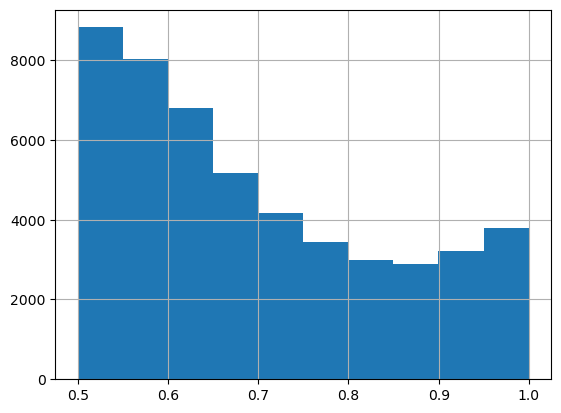

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7726    0.7591    0.7658     29306
         1.0     0.6559    0.6728    0.6642     20010

    accuracy                         0.7240     49316
   macro avg     0.7143    0.7159    0.7150     49316
weighted avg     0.7253    0.7240    0.7246     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7756    0.7610    0.7683     20463
         1.0     0.6614    0.6795    0.6704     14058

    accuracy                         0.7278     34521
   macro avg     0.7185    0.7203    0.7193     34521
weighted avg     0.7291    0.7278    0.7284     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7641    0.7516    0.7578      4400
         1.0     0.6439    0.6593    0.6515      2997

    accuracy                         0.7142      7397
   macro avg     0.7040    0.7055    0.7046 

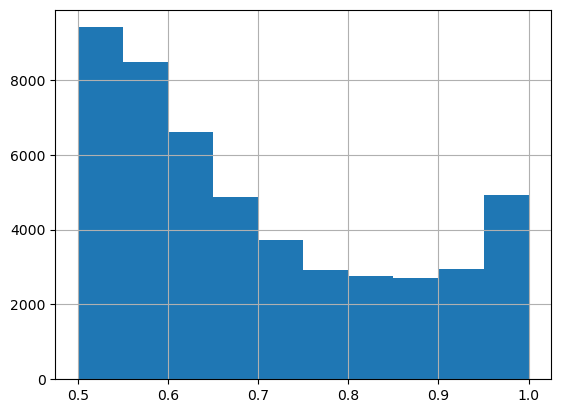

In [37]:
perform_results['O2'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='002/')

## Zero-shot Classification with Embeddings

In [38]:
embeddings = {}
for v in ['O1', 'O2']:
    embeddings[v] = {}
    for l in ['L2', 'L1', 'L0']:
        embeddings[v][l] = {}
        for t in ['val', 'test']:
            embeddings[v][l][t] = {}

In [39]:
embeddings

{'O1': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}},
 'O2': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}}}

### Option 1

In [40]:
args

Namespace(model_state_file='MLP_classifier.pth', save_dir='model_storage/CLIP_ML_NL/', result_dir='results/CLIP_ML_NL/', embedding_size=512, early_stopping_criteria=20, num_epochs=20, seed=42, batch_size=32, embedding_type='multi', fusion_type='concat', hidden_dim=128, learning_rate=5e-05, l2=1e-05, dropout_p=0.1, catch_keyboard_interrupt=True, device='cuda', cuda=True, verbose=True)

In [41]:
args.embedding_type = 'multi'
args.fusion_type = 'complex'

In [42]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '001/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [43]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [44]:
labs = {}
labs['txt_emb'] = stored_data['lab_emb']
empty_img_emb = stored_data['empty_img_emb']
labs['img_emb'] = torch.vstack([empty_img_emb] * labs['txt_emb'].shape[0])

In [45]:
labs['img_emb'].shape

torch.Size([2, 512])

In [46]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [47]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8154    0.7349    0.7731     29306
         1.0     0.6608    0.7563    0.7053     20010

    accuracy                         0.7436     49316
   macro avg     0.7381    0.7456    0.7392     49316
weighted avg     0.7527    0.7436    0.7456     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8244    0.7440    0.7822     20463
         1.0     0.6737    0.7693    0.7183     14058

    accuracy                         0.7543     34521
   macro avg     0.7491    0.7567    0.7502     34521
weighted avg     0.7630    0.7543    0.7562     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7953    0.7180    0.7547      4400
         1.0     0.6377    0.7287    0.6802      2997

    accuracy                         0.7223      7397
   macro avg     0.7165    0.7233    0

In [48]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [49]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [50]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6470    0.8950    0.7511     29306
         1.0     0.6495    0.2849    0.3961     20010

    accuracy                         0.6475     49316
   macro avg     0.6482    0.5900    0.5736     49316
weighted avg     0.6480    0.6475    0.6070     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6472    0.8958    0.7515     20463
         1.0     0.6559    0.2892    0.4014     14058

    accuracy                         0.6488     34521
   macro avg     0.6516    0.5925    0.5765     34521
weighted avg     0.6507    0.6488    0.6089     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6466    0.8952    0.7509      4400
         1.0     0.6467    0.2816    0.3924      2997

    accuracy                         0.6466      7397
   macro avg     0.6467    0.5884    0

In [51]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [52]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [53]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6350    0.8201    0.7158     29306
         1.0     0.5403    0.3096    0.3936     20010

    accuracy                         0.6130     49316
   macro avg     0.5876    0.5649    0.5547     49316
weighted avg     0.5966    0.6130    0.5851     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6347    0.8205    0.7158     20463
         1.0     0.5448    0.3128    0.3974     14058

    accuracy                         0.6137     34521
   macro avg     0.5898    0.5666    0.5566     34521
weighted avg     0.5981    0.6137    0.5861     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6339    0.8198    0.7150      4400
         1.0     0.5354    0.3050    0.3886      2997

    accuracy                         0.6112      7397
   macro avg     0.5847    0.5624    0

### Option 2

In [54]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '002/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file,map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [55]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [56]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [57]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8323    0.7257    0.7754     29306
         1.0     0.6618    0.7859    0.7185     20010

    accuracy                         0.7501     49316
   macro avg     0.7470    0.7558    0.7469     49316
weighted avg     0.7631    0.7501    0.7523     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8423    0.7337    0.7842     20463
         1.0     0.6736    0.8000    0.7314     14058

    accuracy                         0.7607     34521
   macro avg     0.7579    0.7668    0.7578     34521
weighted avg     0.7736    0.7607    0.7627     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8112    0.7127    0.7588      4400
         1.0     0.6420    0.7564    0.6945      2997

    accuracy                         0.7304      7397
   macro avg     0.7266    0.7346    0

In [58]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [59]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [60]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7625    0.7410    0.7516     29306
         1.0     0.6357    0.6620    0.6486     20010

    accuracy                         0.7089     49316
   macro avg     0.6991    0.7015    0.7001     49316
weighted avg     0.7111    0.7089    0.7098     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7656    0.7447    0.7550     20463
         1.0     0.6426    0.6682    0.6551     14058

    accuracy                         0.7135     34521
   macro avg     0.7041    0.7064    0.7051     34521
weighted avg     0.7155    0.7135    0.7143     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7569    0.7336    0.7451      4400
         1.0     0.6258    0.6540    0.6396      2997

    accuracy                         0.7014      7397
   macro avg     0.6913    0.6938    0

In [61]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [62]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [63]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6350    0.8201    0.7158     29306
         1.0     0.5403    0.3096    0.3936     20010

    accuracy                         0.6130     49316
   macro avg     0.5876    0.5649    0.5547     49316
weighted avg     0.5966    0.6130    0.5851     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6347    0.8205    0.7158     20463
         1.0     0.5448    0.3128    0.3974     14058

    accuracy                         0.6137     34521
   macro avg     0.5898    0.5666    0.5566     34521
weighted avg     0.5981    0.6137    0.5861     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6339    0.8198    0.7150      4400
         1.0     0.5354    0.3050    0.3886      2997

    accuracy                         0.6112      7397
   macro avg     0.5847    0.5624    0

In [64]:
results = {}
results['fusion'] = perform_results
results['new_embedding'] = embeddings

In [65]:
import pickle
with open(args.result_dir + 'results_F1.pkl', "wb") as fOut:
    pickle.dump(results, fOut, protocol=pickle.HIGHEST_PROTOCOL)